In [1]:
#tf-text-classification.ipynb
#
#by Joe Hahn
#jmh.datasciences@gmail.com
#24 January 2018

In [2]:
#import matplotlib pandas etc
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pandas as pd
from matplotlib import rcParams
sns.set(font_scale=1.5, font='DejaVu Sans')
pd.set_option('display.max_columns', None)
pd.set_option('display.height', None)
pd.set_option('display.width', None)
import time
time_start = time.time()

height has been deprecated.



In [3]:
#read 'chunks' dataframe; each record contains a random 100-word-long chunk of text from one of 89
#books from the gutenberg project
import pickle
with open('chunks.pkl', 'rb') as fp:
    chunks = pickle.load(fp)
print 'number of records = ', len(chunks)
print 'number of books = ', len(chunks['input_file'].unique())
chunks.head()

number of records =  125271
number of books =  88


,author,author_id,title,input_file,text_chunk
121,Macaulay,57,Critical & Historical Essays,iso/etext00/2cahe10.txt,greatness was to date. They had at last reache...
75423,Kate Milner Rabb,50,National Epics,iso/etext05/8ntle10.txt,crush my heart Even before my lips its tale im...
26296,Anthony Trollope,4,The Last Chronicle Of Barset,iso/etext02/lacob11.txt,explain in the earlier part of this story that...
121957,Carl Von Clausewitz,11,On War,iso/etext99/1onwr10.txt,from the superficial notice of historical even...
125066,Nietzsche,63,Thus Spake Zarathustra,iso/etext99/spzar10.txt,"his heart, ""he there must surely be the higher..."


In [4]:
#show titles and number of chunks
N = pd.DataFrame(chunks.groupby(['author', 'title', 'input_file'])['text_chunk'].count()).reset_index()\
    .sort_values('author')
N = N.rename(columns={'text_chunk':'N_chunks'})
N.head()

,author,title,input_file,N_chunks
0,A.H. Clough,Plutarch's Lives,iso/etext96/plivs10.txt,2200
1,Adam Smith,Wealth Of Nations,iso/etext02/wltnt10.txt,2200
2,Adams,The Education Of Henry Adams,iso/etext00/eduha10.txt,1260
3,Anne C. Lynch Botta,Handbook Of Universal Literature,iso/etext05/8unlt10.txt,1699
4,Anthony Trollope,The Last Chronicle Of Barset,iso/etext02/lacob11.txt,2200


In [5]:
#train-test-validate split
train_size = 0.6
valid_size=0.6   #this is the fraction of the test sample that is assigned to the validation sample
rn_seed = 12
from sklearn.model_selection import train_test_split
train, test = train_test_split(chunks, train_size=train_size, random_state=rn_seed)
valid, test = train_test_split(test, train_size=valid_size, random_state=rn_seed)
print 'records.shape  = ', chunks.shape
print 'train.shape    = ', train.shape
print 'test.shape     = ', test.shape
print 'validate.shape = ', valid.shape

records.shape  =  (125271, 5)
train.shape    =  (75162, 5)
test.shape     =  (20044, 5)
validate.shape =  (30065, 5)


In [6]:
#confirm that all 88 books have records in the training sample
print len(train['input_file'].unique()), len(chunks['input_file'].unique())

88 88


In [7]:
#generate tokenizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer()
corpus = train['text_chunk'].tolist()
tokenizer.fit_on_texts(corpus)
vocabulary_size = len(tokenizer.word_index)
print 'number of distinct words in training samples = ', vocabulary_size
N_inputs = 100
print 'number of inputs ie words per text_chunk = ', N_inputs 

Using TensorFlow backend.


number of distinct words in training samples =  124086
number of inputs ie words per text_chunk =  100


In [8]:
#this helper function extracts and tokenizes x, and extracts y and onehot-encodes it
from keras.utils import np_utils
def tokenize(df, tokenizer):
    corpus = df['text_chunk'].tolist()
    corpus_tokenized = tokenizer.texts_to_sequences(corpus)
    corpus_padded = pad_sequences(corpus_tokenized, maxlen=N_inputs)
    x = np.array(corpus_padded)
    y_ids = df['author_id'].values
    y = np_utils.to_categorical(y_ids)
    return x, y

In [9]:
#get training x,y with x-values being tokenized and y values onehot-encoded
x_train, y_train = tokenize(train, tokenizer)
N_inputs = x_train.shape[1]
N_outputs = y_train.shape[1]
print 'x_train.shape = ', x_train.shape
print 'y_train.shape = ', y_train.shape
print 'N_inputs = ', N_inputs
print 'N_outputs = ', N_outputs
print 'vocabulary_size = ', vocabulary_size, x_train.min(), x_train.max()

x_train.shape =  (75162, 100)
y_train.shape =  (75162, 88)
N_inputs =  100
N_outputs =  88
vocabulary_size =  124086 0 124086


In [10]:
#display a training record
idx = 125
print train.iloc[idx]
text_chunk = train.iloc[idx]['text_chunk']
print text_chunk
print x_train[idx]
print y_train[idx]

author                                                 Macaulay
author_id                                                    57
title                              Critical & Historical Essays
input_file                              iso/etext00/2cahe10.txt
text_chunk    without injuring himself. The advice which he ...
Name: 939, dtype: object
without injuring himself. The advice which he gave to his noble benefactor was generally most judicious. He did all in his power to dissuade the Earl from accepting the Government of Ireland. "For," says he, "I did as plainly see, his overthrow chained as it were by destiny to that journey, as it is possible for a man to ground a judgment upon future contingents." The prediction was accomplished. Essex returned in disgrace. Bacon attempted to mediate between his friend and the Queen; and, we believe, honestly employed all his address for that purpose. But the task which he had 
[  119 17469   101     1  1529    21     8   212     4    11   670  80

In [11]:
#show that the vectorized text preserves word order with punctuation and case dropped
tokens = []
words_marked = text_chunk.split(' ')[0:10]
print words_marked
import string
PERMITTED_CHARS = string.digits + string.ascii_letters
words = [''.join(c.lower() for c in word if (c in PERMITTED_CHARS)) for word in words_marked]
print words
tokens = [tokenizer.word_index[word] for word in words]
print tokens

['without', 'injuring', 'himself.', 'The', 'advice', 'which', 'he', 'gave', 'to', 'his']
['without', 'injuring', 'himself', 'the', 'advice', 'which', 'he', 'gave', 'to', 'his']
[119, 17469, 101, 1, 1529, 21, 8, 212, 4, 11]


In [12]:
#get validation x,y with x-values being tokenized and y values onehot-encoded
x_valid, y_valid = tokenize(valid, tokenizer)
print 'x_valid.shape = ', x_valid.shape
print 'y_valid.shape = ', y_valid.shape

x_valid.shape =  (30065, 100)
y_valid.shape =  (30065, 88)


In [13]:
#display a validation record
idx = 123
print valid.iloc[idx]
print valid.iloc[idx]['text_chunk']
print x_valid[321]
print y_valid[321]

author                                          Thomas Bulfinch
author_id                                                    78
title                                      Bulfinch'S Mythology
input_file                              iso/etext04/bllfn10.txt
text_chunk    So when she had told her tale, the tears ran o...
Name: 52975, dtype: object
So when she had told her tale, the tears ran out of the king's eyes; and all the lords were forward to advise the king to be accorded with Sir Launcelot, save only Sir Gawain; and he said, "My lord, mine uncle, what will ye do? Will you now turn back, now you are so far advanced upon your journey? If ye do all the world will speak shame of you." "Nay," said King Arthur, "I will do as ye advise me; but do thou give the damsel her answer, for I may not speak to her for pity." Then 
[ 1621   139    31 27117     7    31    63    18  2445     4  3171     1
   157   340    23   511    10   664  1863     1    91 30168   263     2
    26     2    26    

In [14]:
#this LSTM model was adapted from 
#http://www.developintelligence.com/blog/2017/06/practical-neural-networks-keras-classifying-yelp-reviews
from keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, MaxPooling1D
from keras.models import Sequential
def build_lstm_model(N_inputs, N_outputs, vocabulary_size, embedding_vector_length, conv_kernel_size, dropout_fraction):
    model = Sequential()
    model.add(Embedding(vocabulary_size, embedding_vector_length, input_length=N_inputs))
    conv_layer_size = embedding_vector_length/2
    model.add(Conv1D(conv_layer_size, conv_kernel_size, activation='relu'))
    model.add(Dropout(dropout_fraction))
    pool_size = int(conv_kernel_size/2)
    model.add(MaxPooling1D(pool_size=pool_size))
    lstm_size = int(embedding_vector_length/2)
    model.add(LSTM(lstm_size, activation='tanh')) #try linear, tanh, relu
    model.add(Dropout(dropout_fraction))
    model.add(Dense(N_outputs, activation='sigmoid'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [15]:
#assemble lstm model
N_training_epochs = 10
batch_size = 700
embedding_vector_length = 500
conv_kernel_size = 60
dropout_fraction = 0.67
print 'N_training_epochs = ', N_training_epochs
print 'batch_size = ', batch_size
print 'number of training + validation samples = ', x_train.shape[0] + x_valid.shape[0]
print 'vocabulary_size = ', vocabulary_size
print 'embedding_vector_length = ', embedding_vector_length
print 'conv_kernel_size = ', conv_kernel_size
print 'dropout_fraction = ', dropout_fraction
print 'N_inputs = ', N_inputs, x_train.shape[1]
print 'N_outputs = ', N_outputs, y_train.shape[1]
print 'rn_seed = ', rn_seed
import random
random.seed(rn_seed)
lstm_model = build_lstm_model(N_inputs, N_outputs, vocabulary_size, embedding_vector_length, conv_kernel_size,
    dropout_fraction)

N_training_epochs =  10
batch_size =  700
number of training + validation samples =  105227
vocabulary_size =  124086
embedding_vector_length =  500
conv_kernel_size =  60
dropout_fraction =  0.67
N_inputs =  100 100
N_outputs =  88 88
rn_seed =  12


In [16]:
#fit model to the training data...this takes 40 minutes on g2.2xl instance
from time import time
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir="tf_logs/{}".format(time()))
fit_history = lstm_model.fit(x_train, y_train, epochs=N_training_epochs, batch_size=batch_size, verbose=0, \
    validation_data=(x_valid, y_valid), callbacks=[tensorboard])

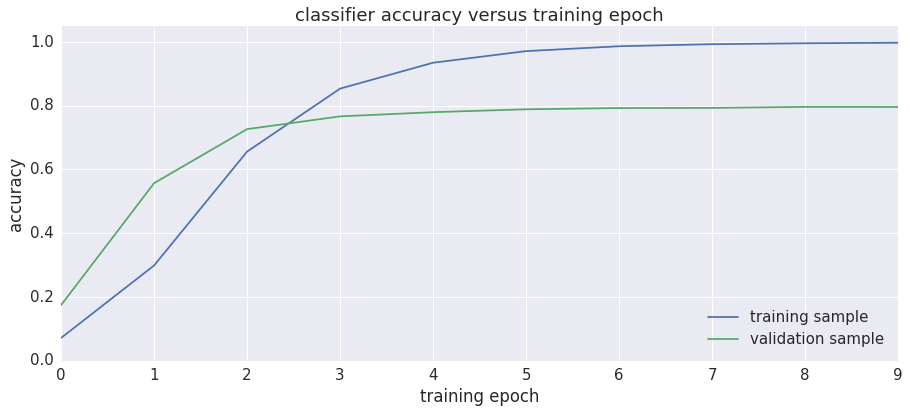

In [17]:
#plot accuracy vs training epoch
fig, ax = plt.subplots(1,1, figsize=(15, 6))
xp = fit_history.epoch
yp = fit_history.history['acc']
ax.plot(xp, yp, label='training sample')
yp = fit_history.history['val_acc']
ax.plot(xp, yp, label='validation sample')
ax.set_title('classifier accuracy versus training epoch')
ax.set_ylabel('accuracy')
ax.set_xlabel('training epoch')
ax.set_ylim(0.0, 1.05)
ax.legend(loc='lower right')
plt.savefig('figs/accuracy.png')

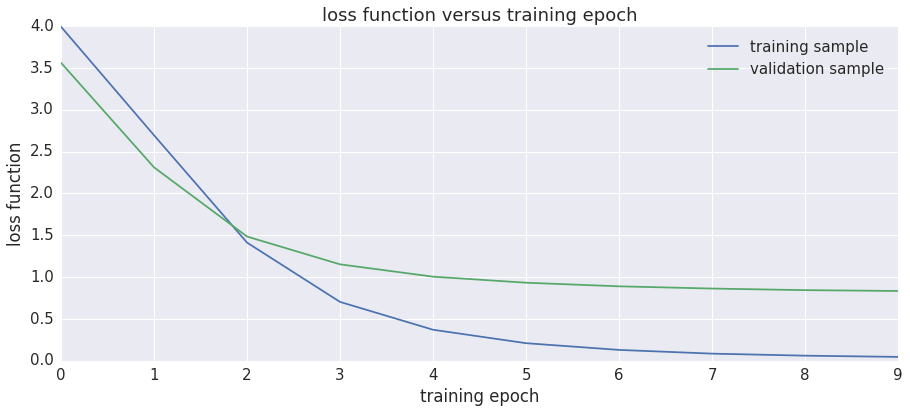

In [18]:
#plot loss function vs training epoch
fig, ax = plt.subplots(1,1, figsize=(15, 6))
xp = fit_history.epoch
yp = fit_history.history['loss']
ax.plot(xp, yp, label='training sample')
yp = fit_history.history['val_loss']
ax.plot(xp, yp, label='validation sample')
ax.set_title('loss function versus training epoch')
ax.set_ylabel('loss function')
ax.set_xlabel('training epoch')
ax.legend()
plt.savefig('figs/loss.png')

In [19]:
#predict authors of the text-chunks in the testing sample
x_test, y_test = tokenize(test, tokenizer)
y_test_predict_2D = lstm_model.predict(x_test)
test = test.reset_index(drop=True)
test['author_id_pred'] = pd.Series([np.argmax(y) for y in y_test_predict_2D])
cols = [u'author', u'title', u'author_id', u'author_id_pred', 'input_file', u'text_chunk']
test[cols][-10:]

,author,title,author_id,author_id_pred,input_file,text_chunk
20034,Adams,The Education Of Henry Adams,2,2,iso/etext00/eduha10.txt,patronage. He knew that his father's appointme...
20035,Victor Hugo,Han D'Islande,85,85,iso/etext04/handi10.txt,pu s'�prendre d'une dame sans consulter ce rus...
20036,Detroyes,Four Arthurian Romances,21,61,iso/etext97/dtroy10.txt,"am not skilled in making such a choice, and ha..."
20037,Samuel Richardson,Pamela,71,71,iso/etext04/pam1w10.txt,in his sordid dignifier? O the wretch! said sh...
20038,Dickens,Bleak House,22,22,iso/etext97/blkhs10.txt,"man, the comfortablest would be that he had ne..."
20039,"Cervantes, In Spanish",Don Quijote,12,12,iso/etext99/2donq10.txt,"desmayado creyendo ser muerto, y parec�ame a m..."
20040,Somerset Maugham,"""Of Human Bondage",75,75,iso/etext95/humbn10.txt,laugh at him and perhaps even to despise him a...
20041,Immanuel Kant,The Critique Of Pure Reason,42,42,iso/etext03/cprrn10.txt,regress in the series of the conditions of a g...
20042,Jules Verne,The Mysterious Island,48,48,iso/etext98/milnd11.txt,"the Chimneys, not far from that part of the do..."
20043,Dumas,The Count Of Monte Cristo,24,24,iso/etext98/crsto12.txt,"of smoke was seen at the stern of the vessel, ..."


In [27]:
#calculate model accuracy vs author
accuracy_list = []
for input_file in test['input_file'].unique():
    idx = test['input_file'] == input_file
    df = test[idx]
    idx = df['author_id'] == df['author_id_pred']
    accuracy = idx.sum()*1.0/idx.count()
    author = df['author'].values[0]
    title = df['title'].values[0]
    N_chunks = (train['input_file'] == input_file).sum()
    d = {'author':author, 'title':title, 'input_file':input_file, 'N_chunks':N_chunks, 'accuracy':accuracy}
    accuracy_list += [d]
accuracy = pd.DataFrame(accuracy_list).sort_values('accuracy', ascending=False).reset_index(drop=True)
accuracy.head(12)

,N_chunks,accuracy,author,input_file,title
0,528,1.000000,Victor Hugo,iso/etext04/handi10.txt,Han D'Islande
1,1313,1.000000,"Cervantes, In Spanish",iso/etext99/2donq10.txt,Don Quijote
2,667,1.000000,Emile Zola,iso/etext04/8lssm10u.txt,L'Assommoir
3,925,0.964444,Immanuel Kant,iso/etext03/cprrn10.txt,The Critique Of Pure Reason
4,1251,0.934473,Ludovico Ariosto,iso/etext96/orfur10.txt,Orlando Furioso
5,825,0.924779,Jules Verne,iso/etext98/milnd11.txt,The Mysterious Island
6,973,0.922131,David Hume,iso/etext03/trthn10.txt,A Treatise Of Human Nature
7,1335,0.918429,Charles Darwin,iso/etext00/dscmn10.txt,The Descent Of Man
8,1333,0.909639,Adam Smith,iso/etext02/wltnt10.txt,Wealth Of Nations
9,834,0.901961,Teresa Of Avila,iso/etext05/8trsa10.txt,The Life Of St. Teresa Of Jesus


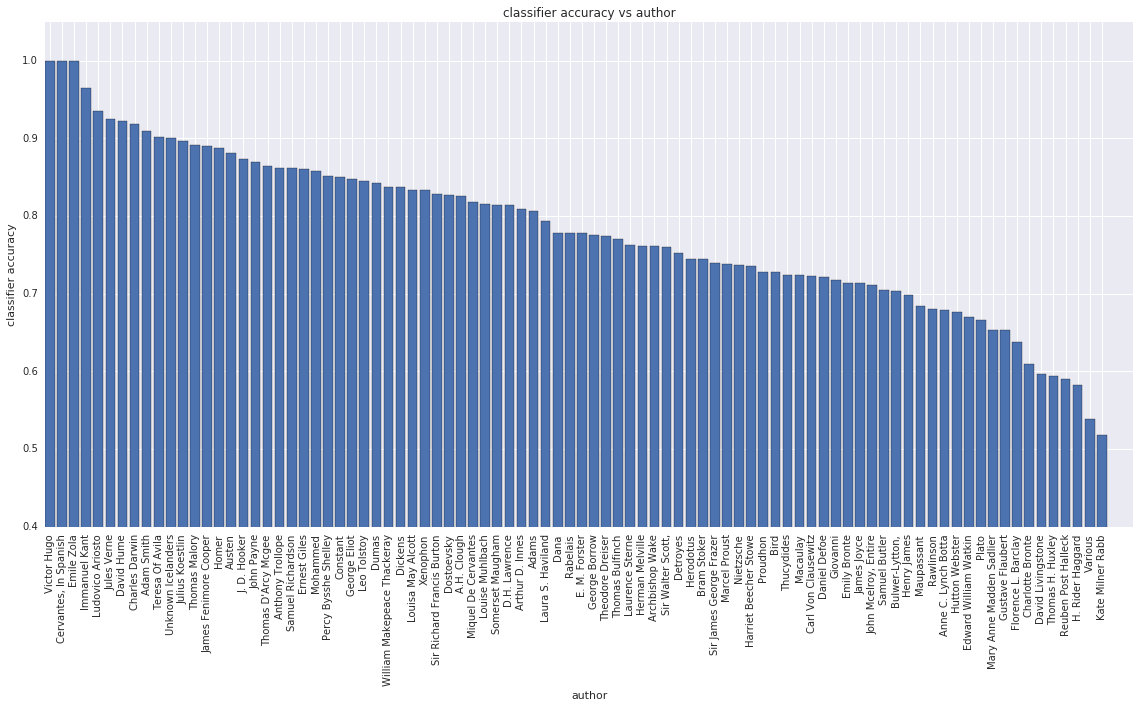

In [21]:
#plot model accuracy vs author
sns.set(font_scale=1.0, font='DejaVu Sans')
fig, ax = plt.subplots(1,1, figsize=(16, 10))
xp = accuracy.index
yp = accuracy['accuracy']
authors = accuracy['author']
ax.bar(xp, yp)
ax.set_xticks(xp+0.4)
ax.set_xticklabels(authors)
ax.set_title('classifier accuracy vs author')
ax.set_ylabel('classifier accuracy')
ax.set_xlabel('author')
plt.xticks(rotation=90)
ax.set_ylim(0.4, 1.05)
plt.tight_layout()
plt.savefig('figs/accuracy_vs_author.png')

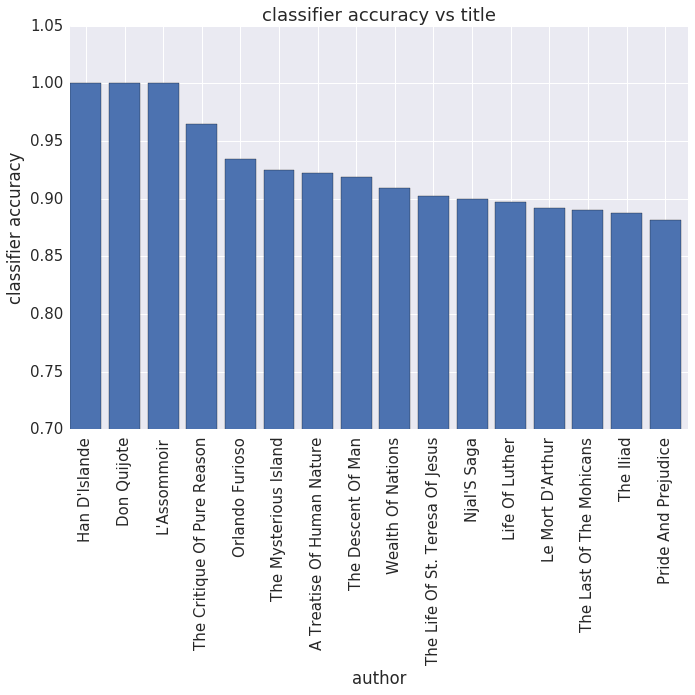

In [22]:
#plot model accuracy vs title, for high-accuracy books
sns.set(font_scale=1.5, font='DejaVu Sans')
fig, ax = plt.subplots(1,1, figsize=(10, 10))
idx = accuracy.index < 16
xp = accuracy.index[idx]
yp = accuracy['accuracy'][idx]
authors = accuracy['title'][idx]
ax.bar(xp, yp)
ax.set_xticks(xp+0.4)
ax.set_xticklabels(authors)
ax.set_title('classifier accuracy vs title')
ax.set_ylabel('classifier accuracy')
ax.set_xlabel('author')
plt.xticks(rotation=90)
ax.set_ylim(0.7, 1.05)
plt.tight_layout()
plt.savefig('figs/accuracy_vs_title-high.png')

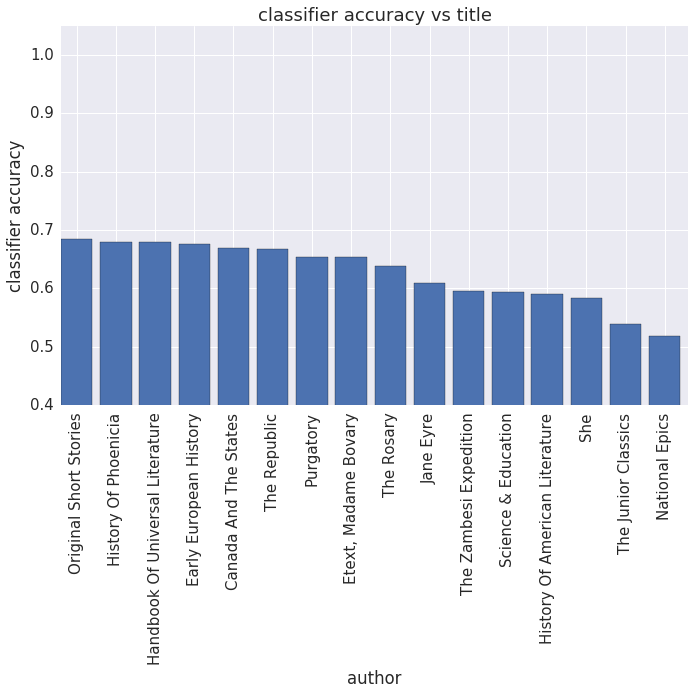

In [23]:
#plot model accuracy vs title, for low-accuracy books
sns.set(font_scale=1.5, font='DejaVu Sans')
fig, ax = plt.subplots(1,1, figsize=(10, 10))
idx = accuracy.index > accuracy.index.max() - 16
xp = accuracy.index[idx]
yp = accuracy['accuracy'][idx]
authors = accuracy['title'][idx]
ax.bar(xp, yp)
ax.set_xticks(xp+0.4)
ax.set_xticklabels(authors)
ax.set_title('classifier accuracy vs title')
ax.set_ylabel('classifier accuracy')
ax.set_xlabel('author')
plt.xticks(rotation=90)
ax.set_ylim(0.4, 1.05)
plt.tight_layout()
plt.savefig('figs/accuracy_vs_title-low.png')

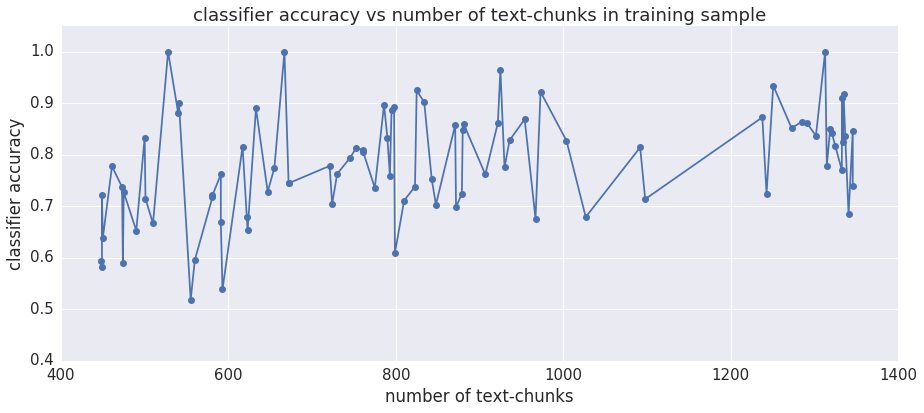

In [24]:
#plot accuracy versus training N_chunks
fig, ax = plt.subplots(1,1, figsize=(15, 6))
df = accuracy.sort_values('N_chunks')
xp = df['N_chunks']
yp = df['accuracy']
ax.plot(xp, yp, marker='o')
ax.set_title('classifier accuracy vs number of text-chunks in training sample')
ax.set_ylabel('classifier accuracy')
ax.set_xlabel('number of text-chunks')
ax.set_ylim(0.4, 1.05)
plt.savefig('figs/accuracy_vs_Nchunks.png')

In [25]:
#done!
print 'training loss fn  = ', fit_history.history['loss'][-1]
print 'validation accuracy = ', fit_history.history['val_acc'][-1]
time_stop = time()
print 'execution time (minutes) = ', (time_stop - time_start)/60.0

training loss fn  =  0.0465925086203
validation accuracy =  0.796041874516
execution time (minutes) =  41.1593954325
